# Simple-GP-RHM

Implementation of the Simplified Gaussian Process Random Hypersurface Model single extended object tracker, as defined in section 4.3.

The target orientation is not estimated in this version of GP-RHM.

This notebooks aims to provide a simple overview. It is split in two parts: First, measurements will drawn and visualized. Afterwards, the formulas for the extended object tracker will be implemented and the algorithm will be applied to the data.

TODOs: 
- Code is written for readability not for efficiency. I.e. not everything concatenated into single numpy expressions everyhwere possible etc.
- I wrote $m_{-}$ as `m_minus` in code - could also name it less verbose?

In [1]:
# import packages
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools

# --- Matplotlib settings:
plt.rc('legend', fontsize=10, handlelength=2)  # legend size
plt.rc('font', size=12)  # fontsize

# colors:
c_gt = 'g'  # color for ground truth
c_meas = 'purple'  # color for measurements
c_est = 'b'  # color for estimates

---
## Data generation
The simple example used here is a stationary, rectangular object where measurements only stem from the object contour.

In this part, data for this model will be generated and visualized.

First of all, the parameters for the object and measurements need to be set:

In [2]:
# --- object: 
object_center_x = 0
object_center_y = 0
object_length = 3  # x axis
object_width = 2 # y axis
# --- concatenate into a single variable x representing the true object location
gt_x = np.array([object_center_x, object_center_y, object_length, object_width])  # essentially an alias for the four parameters

# --- measurements:
# mean number of detections y from the object in each step 
lambda_y = 15
# each true measurement source y will be a 2D vector containing x- and y-position
# covariance of p(z|y) = N(z; y, R)
R = np.eye(2)*0.1

# --- ensure format of parameters is correct
assert R.shape == (2,2), "R needs to be of shape (2,2)"

# --- set up global constants for implementation
N_STEPS = 10  # how many steps to run the simulation for
RNG = default_rng(42)  # numpy random generator 

---
Next, the corresponding measurements will be created, by first sampling a measurement source on the object contour and afterwards adding gaussian noise to generate the measurements passed to the Simple-GP-RHM algorithm.

In [3]:
# first: define a function to get a random point on the contour of a rectangle
def random_rect_contour(center_x, center_y, length, width, n_pts):
    """Randomly sample a point [x, y] from the contour of a rectangle defined by parameters"""
    xs = []
    ys = []
    for n in range(n_pts):
        # first: pick which side to pick - weighted by length and width
        weights = np.array([length, width, length, width])
        weights = weights / sum(weights)

        side = RNG.choice([0, 1, 2, 3], p=weights)  # randomly choose a side to sample from
        # one coordinate is fixed by choice
        # the other is uniform across the length/width
        if side == 0:
            # upper length
            x = RNG.uniform(center_x - length/2, center_x+length/2)
            y = center_y + width/2
        if side == 1:
            # right width
            x = center_x + length/2
            y = RNG.uniform(center_y - width/2, center_y+width/2)
        if side == 2:
            # lower length
            x = RNG.uniform(center_x - length/2, center_x+length/2)
            y = center_y - width/2
        if side == 3:
            # left width
            x = center_x - length/2
            y = RNG.uniform(center_y - width/2, center_y+width/2)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
    
    
# ---
# Use the above function to generate measurements from object contour:
# ---
    
y = []  # measurement sources
z = []  # received measurements
# use the above function to draw the corresponding measurements
for i in range(N_STEPS):
    n_measurements = RNG.poisson(lam=lambda_y)  # number of sources is poisson distributed with mean as specified above
    y_pos_x, y_pos_y = random_rect_contour(object_center_x, object_center_y, object_length, object_width, n_pts=n_measurements)  # get measurement source
    
    y_i = np.vstack([y_pos_x, y_pos_y]).T  #  current measurement sources to y, in shape (n_measurements, 2)
    y.append(y_i)
    # second: draw measurements z_i from y_i
    z_i = []
    for y_i_k in y_i:  # treat each measurement k = 0...n_measurements-1 independently
        z_i_k = RNG.multivariate_normal(mean=y_i_k, cov=R)  # p(z|y) = N(z; y, R)
        z_i.append(z_i_k)
    z_i = np.array(z_i)
    assert z_i.shape == y_i.shape, "Mismatch between z and y shape"
    z.append(z_i)
    
    print("Step: {}/{} - Number of Measurements generated: {}".format(i+1, N_STEPS, n_measurements))

Step: 1/10 - Number of Measurements generated: 18
Step: 2/10 - Number of Measurements generated: 12
Step: 3/10 - Number of Measurements generated: 13
Step: 4/10 - Number of Measurements generated: 21
Step: 5/10 - Number of Measurements generated: 7
Step: 6/10 - Number of Measurements generated: 15
Step: 7/10 - Number of Measurements generated: 14
Step: 8/10 - Number of Measurements generated: 19
Step: 9/10 - Number of Measurements generated: 15
Step: 10/10 - Number of Measurements generated: 17


---
#### Visualize Measurements
Define some necessary functions for plotting and then plot each time step individually.

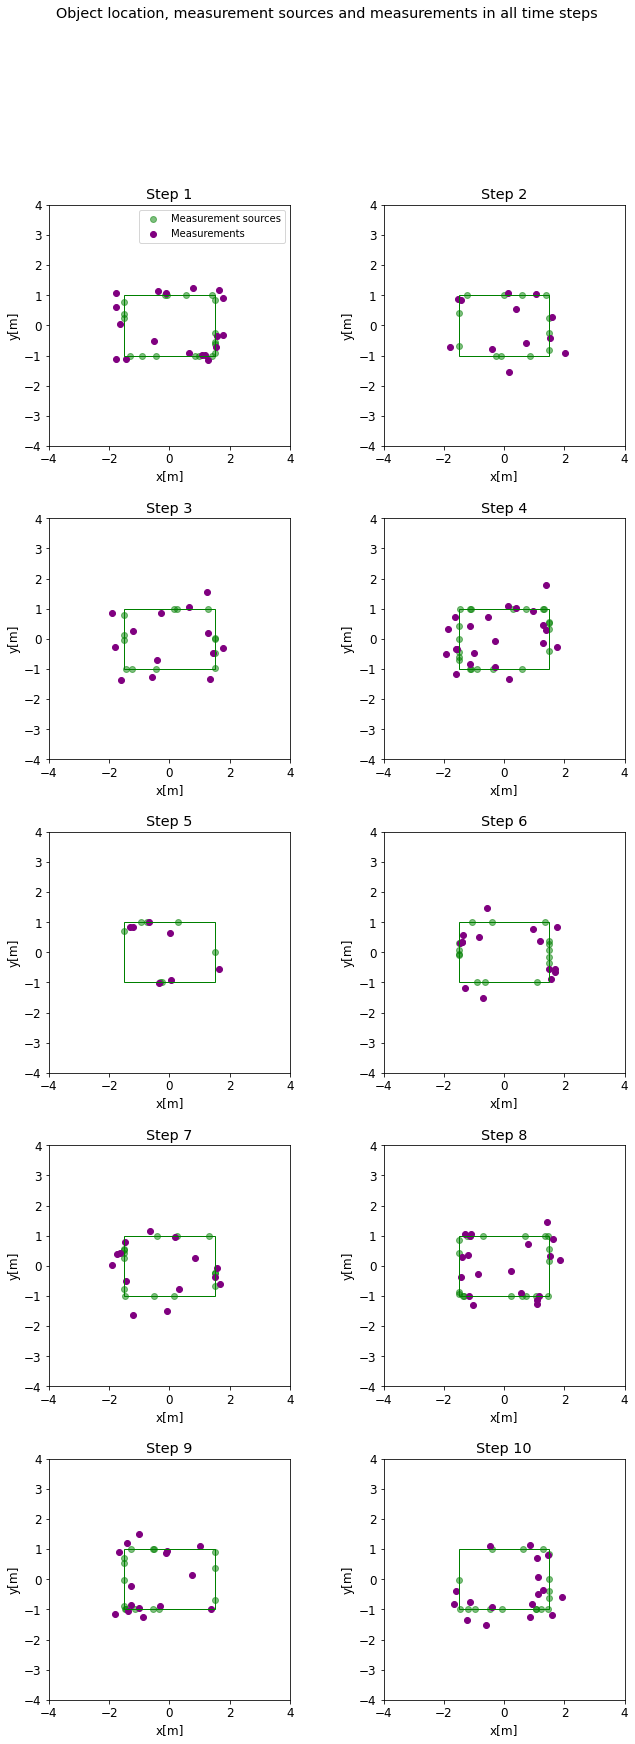

In [4]:
def plt_square(loc, l, ax=None, label_as_m=True):
    """
    Helper function to quickly focus a plot on a location loc with margins l to all sides.
    Can either pass an axis object, or uses the current axis (plt.gca())
    By default also sets axis labeling to 'x[m]' and 'y[m]'
    """
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(loc[0] - l, loc[0] + l)
    ax.set_ylim(loc[1] -l, loc[1] + l)
    ax.set_aspect('equal', adjustable='box')
    
    if label_as_m:
        ax.set_xlabel("x[m]")
        ax.set_ylabel("y[m]")

fig, all_ax = plt.subplots(nrows=int(N_STEPS / 2), ncols=2, figsize=(11, 5.5*int(N_STEPS/2)))
plt.subplots_adjust(hspace=0.3)
for i in range(N_STEPS):
    row = int(i/2)  # row for plots
    col = i % 2  # col for plots
    ax = all_ax[row][col]
    patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(patch_ground_truth)
    ax.set_title("Step {}".format(i+1))
    ax.scatter(y[i][:, 0], y[i][:, 1], c=c_gt, label="Measurement sources", alpha=0.5)
    ax.scatter(z[i][:, 0], z[i][:, 1], c=c_meas, label="Measurements")
    
    plt_square(gt_x[:2], 4, ax)
    
    if i == 0:
        ax.legend()
plt.suptitle("Object location, measurement sources and measurements in all time steps")
plt.show()

---
## Simple-GP-RHM
The next step is to run the extended object tracking algorithm. In this part, the algorithm and all necessary functions are implemented and consequently applied to the data.

In this simple example, we know the object is stationary and therefore skip the time-update ("prediction") step. Instead, we just update with the measurements in each step directly.

The following cells define the relevant variables for the GP:

In [5]:
# DEFINE VARIABLES FOR Simple-GP-RHM

# define H
dim_m = 3  # dimension of the kinematic state: 3 (x,y,speed) 
H = np.hstack([np.eye(2), np.zeros((2, dim_m-2))])

# scaling parameters
s_hat = 1  # fix s to one: measurements stem from the object contour only
sigma_squared_s = 0  # no variance in scaling parameter s

# kernel parameters sigma and l:
sigma_squared_ker = 2
l_ker = np.pi / 4

# number of base points (i.e. size of 'p')
num_base_pts = 25

# define base points phi_1..phi_n
phi_pts = np.linspace(start=0, stop=2*np.pi, num=num_base_pts, endpoint=False)

In [6]:
# DEFINE FUNCTIONS USED BY Simple-GP-RHM

def k(phi_1, phi_2):
    """
    Kernel of the Gaussian process. Here defined as in equation (43)
    """
    d = np.abs(phi_1 - phi_2)
    expo = 2 * np.sin((1/2) * d)**2
    expo /= l_ker**2
    return sigma_squared_ker * np.exp(-expo)
    
def u(phi):
    """
    Function u(phi) as defined in equation (36): Given an input angle phi, returns [cos(phi) sin(phi)]^T
    """
    u = np.array([np.cos(phi), np.sin(phi)])
    u = np.reshape(u, (2, -1))  
    return u


def angle(x, y):
    """
    Given two two dimensional vectors x and y, calculates the angle between them (in radians, from 0 to 2*pi).
    """
    x = np.array(x)
    y = np.array(y)
    x = x /np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    dot = x @ y
    det = x[0] * y[1] - x[1] * y[0]
    a = np.arctan2(det, dot)
    a = (a+2*np.pi) % (2*np.pi)  # cast into [0, 2*pi] 
    a = 2 * np.pi - a  # "flip" so we go clockwise instead of counter-clockwise
    return a

def K(phi):
    """
    K(phi) as defined in equation (45)
    """
    K = np.array([k(phi, phi_n) for phi_n in phi_pts])
    K = np.reshape(K, (-1, len(K)))  
    return K


In [7]:
# define K_p, and invert it (K_p_inv) for later use
# given in equation (42)
K_p = [[k(phi_pts[i], phi_pts[j]) for i in range(len(phi_pts))] for j in range(len(phi_pts))]
K_p = np.array(K_p).T  # transpose because of the order above, but K is symmetric anyway
K_p_inv = np.linalg.inv(K_p)


# use K_p_inv for the definition of A(phi)

def A(phi):
    """
    A(phi) as defined in equation (47)
    """
    if not isinstance(phi+0.0, float):
        # unpack phi to scalar if necessary:
        phi = phi[0]
    A = K(phi) @ K_p_inv
    return A

# ----
def C_e(phi):
    """Given in equation (48)"""
    C = k(phi, phi) - K(phi) @ K_p_inv @ K(phi).T
    return C


---
Given the above definitions, the "update" function can be implemented, as shown in Table IV:

In [8]:
def update_gp(z, m_minus, p_minus, C_m_minus, C_p_minus):
    """
    Perform an update for the Simple-GP-RHM Filter, according to Table IV.
    
    Necessary parameters are a measurement z and prior estimates m_minus, p_minus, C_m_minus, C_p_minus
    
    Returns updated estimates m_plus, p_plus, C_m_plus, C_p_plus
    """
    phi = angle(z - H @ m_minus, u(0))
    B_phi = s_hat * (u(phi) @ A(phi))
    
    if sigma_squared_s != 0:
        C_w = sigma_squared_s * ( (u(phi) @ A(phi)) @ C_p_minus @  (u(phi) @ A(phi)).T) + sigma_squared_s * u(phi) @ C_e(phi) @ u(phi).T + R
    else:
        # formula simplifies significantly!
        C_w = R
    
    C_z = (B_phi @ C_p_minus @ B_phi.T) + H @ C_m_minus @ H.T + C_w
    C_mz = C_m_minus @ H.T
    C_pz = C_p_minus @ B_phi.T

    z_bar = B_phi @ p_minus + (H@m_minus).reshape((2,1))
    # invert C_z once here
    C_z_inv = np.linalg.inv(C_z)
    
    m_plus = m_minus + ( C_mz @ C_z_inv @ (z.reshape((2,1)) - z_bar).reshape(2) )
    C_m_plus = C_m_minus - ( C_mz @ C_z_inv @ C_mz.T)

    # in order to calculate p_plus, we need to reshape parts of the equation for numpy, so split it up in two parts for readability:
    p_add = ( C_pz @ C_z_inv @ (z.reshape((2,1)) - z_bar))  # calculate necessary part
    p_add = np.reshape(p_add, (len(p_add), -1))  # reshape to make sure numpy adds everything correctly
    p_plus = p_minus + p_add  # finalize p_plus
    
    C_p_plus = C_p_minus - ( C_pz @ C_z_inv @ C_pz.T)
    
    return m_plus, p_plus, C_m_plus, C_p_plus

In [9]:
# DEFINE UTILITY FUNCTIONS FOR VISUALIZATION

def pol2cart(rho, phi):
    """
    Help function to convert from polar(radius rho, angle phi) to cartesian coordinates.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
    
def plot_extent(m, p, n_pts=100):
    """
    Plot the extent of a target specified by state m and base points p.
    
    The plot is added to the current axis, which you can select using for example `plt.sca(<axis object>)`
    
    n_pts specifies how many points to use for the plot, essentially the angular resolution
    c specifies the plot color
    """
    # make sure format is as desired
    p = p.reshape((len(p),))
    m = m.reshape((len(m),))
    
    # get the angles including overlap on the last one (endpoint=True) to prevent a "hole" in the visualization 
    scatter_angles = np.linspace(0, 2*np.pi, n_pts, endpoint=True)
    
    # use equation (52) to get to cartesian points at desired angles
    ex = np.array([s_hat * u(phi) @ A(phi) @ p + H @ m for phi in scatter_angles])
    
    # plot the result
    plt.gca().plot(ex[:, 0], ex[:, 1], c=c_est, label="Extent Estimate")
    plt.gca().scatter(m[0], m[1], c=c_est, marker='x', label="Location Estimate")

    
def plot_radial_fct(p, n_pts=100):
    """
    Plot the radial function estimate based on basis points p. Granularity can be set using parameter n_pts.
    """
    x = np.linspace(0, 2*np.pi, n_pts, endpoint=False)
    y = [A(phi) @ p for phi in x]
    plt.gca().plot(x, y, label="Radial Function")
    plt.gca().set_ylim(0, max(y)+0.5)  # make sure y-axis starts at 0 and covers everything

### Simple-GP-RHM tracking

With all necessary functions defined, the algorithm can now be applied to the data.

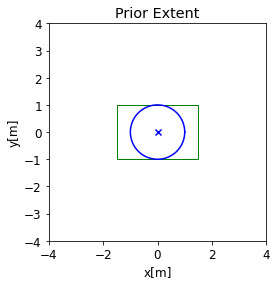

In [10]:
# basis points p with covariance C_p
# state m with covariance C_m
m_init = np.array([0, 0, 0]) * 1.0  # position 0,0 and velocity 0 too
C_m_init = np.eye(3)*0.01
p_init = np.array([1]*num_base_pts)  # start with a circle
C_p_init = np.eye(num_base_pts)


# Take a look at the prior
plt.title("Prior Extent")
patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor=c_gt, facecolor='none')
plt.gca().add_patch(patch_ground_truth)
plot_extent(m_init, p_init)
plt_square(gt_x[:2], 4)
plt.show()

Iterate all time steps and pass the measurements to the GP `update` function:

In [11]:
# Arrays to store intermediate results:
m_list = []
Cm_list = []
p_list = []
Cp_list = []

# Initial values:
m = m_init
C_m = C_m_init
p = p_init  # start with a circle
C_p = C_p_init

p = np.reshape(p, (len(p), -1))
for i in range(N_STEPS):
    # get measurements z_i for this step
    z_i = z[i]
    for z_i_k in z_i:  # pass each measurement to update individually
        # we skip the predict step in this simple stationary example!
        m, p, C_m, C_p = update_gp(z_i_k, m, p, C_m, C_p)  # update with new measurement
    m_list.append(m)
    Cm_list.append(C_m)
    p_list.append(p)
    Cp_list.append(C_p)

Finally, show the results across all time steps:

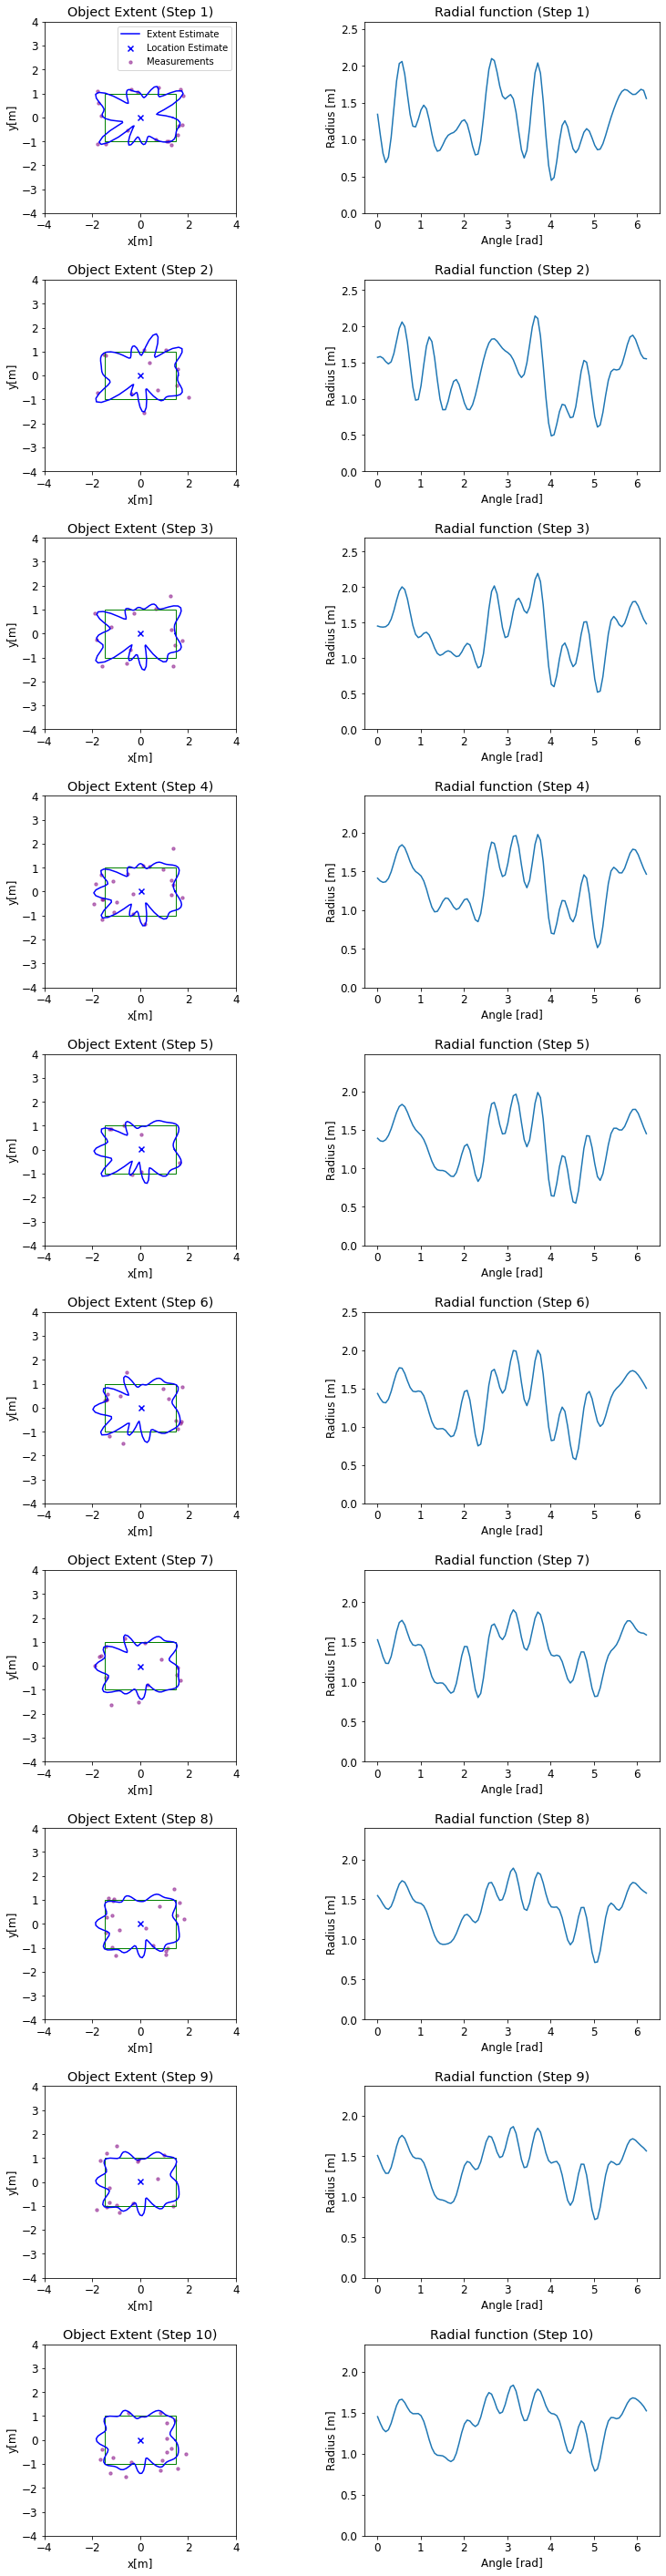

In [12]:
# Visualize each step indivdually:
SIZE = 4  # size parameter for subplots
fig, all_ax = plt.subplots(nrows=int(N_STEPS), ncols=2, figsize=(SIZE*3, SIZE*int(N_STEPS)))
fig.tight_layout(pad=4.0)
for i in range(N_STEPS):
    # --- EXTENT ESTIMATE:
    ax = all_ax[i][0]
    plt.sca(ax)
    plot_extent(m_list[i], p_list[i])
    
    # add ground truth:
    patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor=c_gt, facecolor='none')
    ax.add_patch(patch_ground_truth)
    
    # add measurements 
    ax.scatter(z[i][:, 0], z[i][:, 1], c=c_meas, label="Measurements", alpha=0.5, s=11)
    
    # add title and formatting:
    ax.set_title("Object Extent (Step {})".format(i+1))
    plt_square(gt_x[:2], 4)

    if i == 0:
        ax.legend()
    
    # --- RADIAL FUNCTION:
    ax = all_ax[i][1]
    plt.sca(ax)
    plot_radial_fct(p_list[i].reshape(len(p_list[i]), ))
    ax.set_title("Radial function (Step {})".format(i+1))
    ax.set_xlabel("Angle [rad]")
    ax.set_ylabel("Radius [m]")
plt.show()